In [1]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import izip
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns

%matplotlib inline

In [2]:
#connect to database
dbname = 'statcast'
username = 'ribeck'
pswd = ''

engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))
print engine.url

con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

postgresql://ribeck:@localhost/statcast


In [3]:
def bin_lookup_flat(v_query, a_query, v_range, a_range, num_edges):
    v_min, v_max = v_range
    v_binsize = (v_max - v_min)/(num_edges - 1.)
    
    a_min, a_max = a_range
    a_binsize = (a_max - a_min)/(num_edges - 1.)
    
    v_bin = int(np.floor((v_query - v_min)/v_binsize))
    a_bin = int(np.floor((a_query - a_min)/a_binsize))
    
    return v_bin * (num_edges - 1) + a_bin

In [4]:
def classify_batted_ball(hit_speed, hit_angle, v_range, a_range, num_edges):
    #use these lines if you want to import the previous cluster definitions
    #make sure the old files haven't been over-written by the above cell
    kmeans_labels = np.load("kmeans_labels.npy")
    labels_indexes = np.load("labels_indexes.npy")
    
    bin_flat = bin_lookup_flat(hit_speed, hit_angle, v_range, a_range, num_edges)

    ball_type = kmeans_labels[np.where(labels_indexes == bin_flat)][0]

    return ball_type

In [5]:
#join fangraphs tables and qualifying-players-query on player names
#gets total balls in play and speed rating and pull% for each player with >= min_bip BIP

min_bip = 100
sql_query = """
select s.player_name, s.total_bip, f.spd, fb.pull from
(select player_name, count(*) as total_bip from statcast_data_table where hit_speed != 0 group by player_name having count(*)> %d ) as s
join fangraphs_data_table as f on s.player_name=f.name
join fangraphs_bb_data_table as fb on s.player_name=fb.name
group by s.player_name, s.total_bip, f.spd, fb.pull order by s.total_bip desc;
""" % min_bip
qualifying_players = pd.read_sql_query(sql_query, con)

In [6]:
qualifying_players.head()

,player_name,total_bip,spd,pull
0,Jose Altuve,697,5.9,0.442
1,Ian Kinsler,642,5.6,0.423
2,Alcides Escobar,640,5.8,0.334
3,Kyle Seager,638,3.0,0.427
4,Adrian Beltre,631,3.1,0.397


In [7]:
def query_for_player_events(name):
    fixed_name = name.replace("'", "''")
    sql_query = """
        select player_name, hit_speed, hit_angle, (case 
        when events='Single' then 1
        when events='Double' then 2 
        when events='Triple' then 3
        when events='Home Run' then 4 
        else 0 end) as bases_acquired
        from statcast_data_table where hit_speed != 0 and player_name='%s';""" % fixed_name

    player_events_df = pd.read_sql_query(sql_query, con)
    return player_events_df

In [8]:
#some rounding errors on splitting the quarters, but it's ok

def create_player_events_subset(df_in, subset):
    if subset == 'all':
        df_out = df_in
    elif subset == 'odd':
        df_out = df_in.iloc[1::2]
    elif subset == 'even':
        df_out = df_in.iloc[::2]
    elif subset == 'half1':
        half_point = len(df_in)/2
        df_out = df_in[:half_point]
    elif subset == 'half2':
        half_point = len(df_in)/2
        df_out = df_in[half_point:]
    elif subset == 'q1':
        q_point = len(df_in)/4
        df_out = df_in[:q_point]
    elif subset == 'q2':
        q_point = len(df_in)/4
        df_out = df_in[q_point:2*q_point]
    elif subset == 'q3':
        q_point = len(df_in)/4
        df_out = df_in[2*q_point:3*q_point]
    elif subset == 'q4':
        q_point = len(df_in)/4
        df_out = df_in[3*q_point:]
    
    return df_out

In [9]:
def player_actual_hit_values(player_events_df, subset):
    
    total_bases = 0.

    df_subset = create_player_events_subset(player_events_df, subset)
    total_bip = len(df_subset)
    
    for i in xrange(total_bip): 
        bases_acquired = df_subset.iloc[i]['bases_acquired']
        total_bases += bases_acquired
    
    return total_bases, total_bip

In [10]:
def player_hit_type_counts(player_events_df, subset):

    hit_type_counts = np.full(k, 0.)

    df_subset = create_player_events_subset(player_events_df, subset)
    total_bip = len(df_subset)
    
    for i in xrange(total_bip):
    
        hit_speed = df_subset.iloc[i]['hit_speed']
        hit_angle = df_subset.iloc[i]['hit_angle']
        
        ball_type = classify_batted_ball(hit_speed, hit_angle, v_range, a_range, num_edges)
        hit_type_counts[ball_type] += 1
    
    return hit_type_counts

In [11]:
k=7
num_edges = 50
v_range = [10., 130.]
a_range = [-100., 100.]

In [12]:
def batted_ball_rates_to_df(qualifying_players, subset1, subset2):

    hit1 = []
    hit2 = []
    hit3 = []
    hit4 = []
    hit5 = []
    hit6 = []
    hit7 = []

    slg1 = []
    slg2 = []

    for i in xrange(len(qualifying_players)):
        name = qualifying_players.iloc[i]['player_name']
        player_events_df = query_for_player_events(name)
    
        #add up value for each hit type in subset1
        hit_type_counts = player_hit_type_counts(player_events_df, subset1)
        total_bip1 = sum(hit_type_counts)
    
        hit1.append(hit_type_counts[0]/total_bip1)
        hit2.append(hit_type_counts[1]/total_bip1)
        hit3.append(hit_type_counts[2]/total_bip1)
        hit4.append(hit_type_counts[3]/total_bip1)
        hit5.append(hit_type_counts[4]/total_bip1)
        hit6.append(hit_type_counts[5]/total_bip1)
        hit7.append(hit_type_counts[6]/total_bip1)
    
        #add up actual production in subset2
        total_bases2, total_bip2 = player_actual_hit_values(player_events_df, subset2)
        slg2.append(total_bases2/total_bip2)
        
        if subset1 != subset2:
            #add up actual production in subset1
            total_bases1, total_bip1 = player_actual_hit_values(player_events_df, subset1)
            slg1.append(total_bases1/total_bip1)
        else:
            slg1.append(total_bases2/total_bip2)
            
    qualifying_players['hit1'] = hit1
    qualifying_players['hit2'] = hit2
    qualifying_players['hit3'] = hit3
    qualifying_players['hit4'] = hit4
    qualifying_players['hit5'] = hit5
    qualifying_players['hit6'] = hit6
    qualifying_players['hit7'] = hit7
    qualifying_players['slg1'] = slg1
    qualifying_players['slg2'] = slg2
    
    return qualifying_players

In [13]:
qualifying_players = batted_ball_rates_to_df(qualifying_players, 'q1', 'q2')

In [14]:
X = qualifying_players[['hit1', 'hit2', 'hit3', 'hit4', 'hit5', 'hit6', 'hit7', 'spd', 'pull']]
y = qualifying_players['slg2']
weights = qualifying_players['total_bip']

In [15]:
linreg = LinearRegression()
linreg.fit(X, y, sample_weight = weights)
linreg.score(X, y, sample_weight = weights)

0.23261955208902774

In [16]:
#print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

0.709497263361
[-0.37243296  0.95015575 -0.28212953 -0.20476562 -0.54604353  1.19853275
 -0.74331685  0.00149053  0.32077773]


In [16]:
#just each player's first data half as training data
#THIS IS FOR VALIDATION

#regression run with features from q1, target from q2
y_int_q1 = 0.709497263361
coeffs_q1 = np.array([-0.37243296, 0.95015575, -0.28212953, -0.20476562, -0.54604353, 1.19853275, -0.7433168, 0.00149053, 0.32077773])

#regression run with features from q2, target from q1
y_int_q2 = 0.784651521357
coeffs_q2 = np.array([-0.52385745, 1.18926581, -0.33161038, -0.47360222, -0.61849924, 1.16567828, -0.4073748, 0.00778816, 0.29302653])

#average regression parameters - this is the training model for validation
y_int_avg = (y_int_q1 + y_int_q2)/2.
coeffs_avg = (coeffs_q1 + coeffs_q2)/2.

In [14]:
qualifying_players = batted_ball_rates_to_df(qualifying_players, 'half1', 'half2')

In [17]:
X = qualifying_players[['hit1', 'hit2', 'hit3', 'hit4', 'hit5', 'hit6', 'hit7', 'spd', 'pull']]
y = qualifying_players['slg2']
weights = qualifying_players['total_bip']

In [18]:
#uses averaged coefficients from cell to give predicted slg based on each player's first half
#run on subset1 = half1, subset2 = half2, gives predicted slg and luck based only on half1-derived model
y_pred_half1 = y_int_avg + X['hit1'].values*coeffs_avg[0] + X['hit2'].values*coeffs_avg[1] + X['hit3'].values*coeffs_avg[2] + \
X['hit4'].values*coeffs_avg[3] + X['hit5'].values*coeffs_avg[4] + X['hit6'].values*coeffs_avg[5] + \
X['hit7'].values*coeffs_avg[6] + X['spd'].values*coeffs_avg[7] + X['pull'].values*coeffs_avg[8]

0.35555717885
(0.87530013700703191, -0.0025451352921208774)


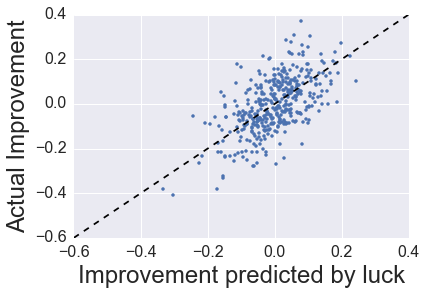

In [92]:
slg_half1 = qualifying_players['slg1']
slg_half2 = qualifying_players['slg2']
luck_half1 = slg_half1 - y_pred_half1

#improvement from half1 to half2
improvement = np.array(slg_half2)-np.array(slg_half1)

slope_fit, y_int_fit, r_value, p_value, std_err = stats.linregress(-luck_half1, improvement)

x = np.arange(-0.6, 0.5, 0.1)
plt.xlabel('Improvement predicted by luck', fontsize=24)
plt.ylabel('Actual Improvement', fontsize=24)
plt.ylim(-.6,.4)
plt.xlim(-.6,.4)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(-luck_half1, improvement, '.')
#plt.plot(x, slope_fit*x + y_int_fit, 'k-')
plt.plot(x, x, 'k--')
print (r_value**2)
print(slope_fit, y_int_fit)

(array([  6.,  13.,  26.,  51.,  85.,  95.,  68.,  42.,  17.,   3.]),
 array([-0.29091365, -0.23433141, -0.17774917, -0.12116692, -0.06458468,
        -0.00800244,  0.0485798 ,  0.10516205,  0.16174429,  0.21832653,
         0.27490878]),
 <a list of 10 Patch objects>)

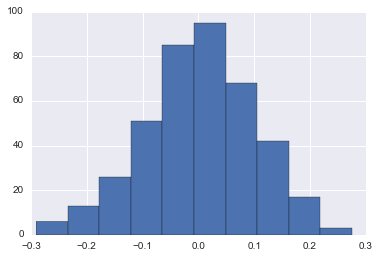

In [21]:
plt.hist(-luck_half1-improvement)

In [27]:
stdev = np.std(luck_half1)
print(stdev)
unlucky = luck_half1.values[np.where(luck_half1 < -stdev)]

0.0840433443583


In [28]:
ix = np.in1d(luck_half1.ravel(), unlucky).reshape(luck_half1.shape)
improvement_of_unlucky = improvement[np.where(ix)]

(array([ 3.,  6.,  6.,  7.,  9.,  9.,  6.,  5.,  3.,  2.]),
 array([-0.08565244, -0.04659939, -0.00754634,  0.0315067 ,  0.07055975,
         0.1096128 ,  0.14866585,  0.1877189 ,  0.22677195,  0.265825  ,
         0.30487805]),
 <a list of 10 Patch objects>)

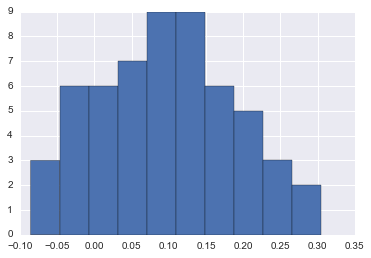

In [29]:
plt.hist(improvement_of_unlucky)

In [30]:
len(improvement_of_unlucky)

56

In [54]:
float(len(np.where(improvement_of_unlucky<0)[0]))/len(improvement_of_unlucky)

0.16071428571428573

0.21641776756
(0.45420952858808955, -0.0042865652086985923)


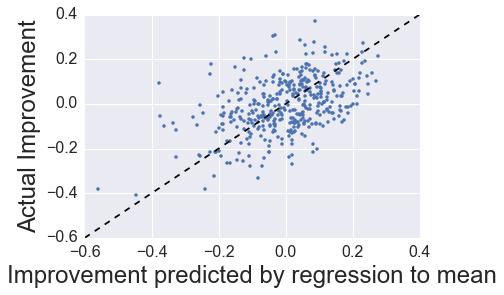

In [84]:
deviation_from_mean = slg_half1 - np.average(slg_half1) 

slope_fit, y_int_fit, r_value, p_value, std_err = stats.linregress(-deviation_from_mean, improvement)

x = np.arange(-0.6, 0.5, 0.1)
plt.xlabel('Improvement predicted by regression to mean', fontsize=24)
plt.ylabel('Actual Improvement', fontsize=24)
plt.ylim(-.6,.4)
plt.xlim(-.6,.4)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(-deviation_from_mean, improvement, '.')
#plt.plot(x, slope_fit*x + y_int_fit, 'k-')#
plt.plot(x, x, 'k--')
print (r_value**2)
print(slope_fit, y_int_fit)

In [115]:
from sklearn import metrics

print np.sqrt(metrics.mean_squared_error(-luck_half1, improvement))
print np.sqrt(metrics.mean_squared_error(-deviation_from_mean, improvement))

0.0996165271166
0.129230103302
